<a href="https://colab.research.google.com/github/zianafique/earthquake_prediction/blob/master/earthquake_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

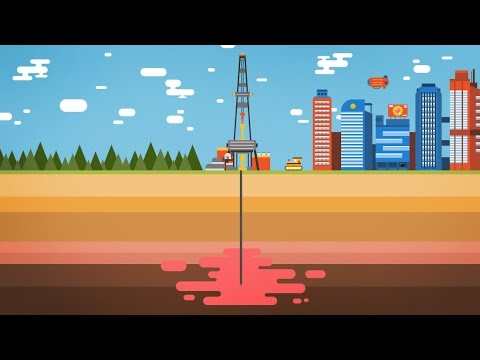

In [1]:

from IPython.display import YouTubeVideo
YouTubeVideo('Uti2niW2BRA')

In [3]:
#install and import dependencies 
#to use kaggle dataset
!pip install kaggle

#math operation
!pip install numpy

#MACHINE Learning
!pip install catboost


     |████████████████████████████████| 64.7MB 63kB/s 


In [0]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt


In [5]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:

#list competitions
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       3006           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      22236           False  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       5147           False  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        399           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       1929           False  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       6878   

In [7]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 43.1MB/s]
  0% 0.00/330k [00:00<?, ?B/s]
100% 330k/330k [00:00<00:00, 108MB/s]
  0% 0.00/321k [00:00<?, ?B/s]
100% 321k/321k [00:00<00:00, 101MB/s]
  0% 0.00/320k [00:00<?, ?B/s]
100% 320k/320k [00:00<00:00, 106MB/s]
  0% 0.00/319k [00:00<?, ?B/s]
100% 319k/319k [00:00<00:00, 103MB/s]
  0% 0.00/332k [00:00<?, ?B/s]
100% 332k/332k [00:00<00:00, 107MB/s]
  0% 0.00/324k [00:00<?, ?B/s]
100% 324k/324k [00:00<00:00, 105MB/s]
  0% 0.00/315k [00:00<?, ?B/s]
100% 315k/315k [00:00<00:00, 97.8MB/s]
  0% 0.00/325k [00:00<?, ?B/s]
100% 325k/325k [00:00<00:00, 105MB/s]
  0% 0.00/320k [00:00<?, ?B/s]
100% 320k/320k [00:00<00:00, 102MB/s]
  0% 0.00/310k [00:00<?, ?B/s]
100% 310k/310k [00:00<00:00, 94.1MB/s]
  0% 0.00/329k [00:00<?, ?B/s]
100% 329k/329k [00:00<00:00, 107MB/s]
  0% 0.00/325k [00:00<?, ?B/s]
100% 325k/325k [00:00<00:00, 108MB/s]
  0% 0.00/324k [00:00<?, ?B/s]
100% 324k/324k [00:00<00:00, 104MB/s]
  0% 0.00/319k [00:00<?, ?B/s]


In [8]:
#unzip training data for usage, will take about 5 minutes (its big)
!ls
!unzip train.csv.zip
!ls

sample_data	       seg_0042cc.csv  seg_006e4a.csv  seg_00e5f7.csv
sample_submission.csv  seg_004314.csv  seg_007a37.csv  seg_00f3b9.csv
seg_00030f.csv	       seg_004cd2.csv  seg_00a37e.csv  seg_010eab.csv
seg_0012b5.csv	       seg_004ee5.csv  seg_00be11.csv  seg_0125d9.csv
seg_00184e.csv	       seg_004f1f.csv  seg_00c35b.csv  train.csv.zip
seg_003339.csv	       seg_00648a.csv  seg_00cc91.csv
Archive:  train.csv.zip
  inflating: train.csv               
sample_data	       seg_0042cc.csv  seg_006e4a.csv  seg_00e5f7.csv
sample_submission.csv  seg_004314.csv  seg_007a37.csv  seg_00f3b9.csv
seg_00030f.csv	       seg_004cd2.csv  seg_00a37e.csv  seg_010eab.csv
seg_0012b5.csv	       seg_004ee5.csv  seg_00be11.csv  seg_0125d9.csv
seg_00184e.csv	       seg_004f1f.csv  seg_00c35b.csv  train.csv
seg_003339.csv	       seg_00648a.csv  seg_00cc91.csv  train.csv.zip


In [0]:

#Extract training data into a dataframe for further manipulation
train= pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16,'Time_of_failure' : np.float64})

In [10]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


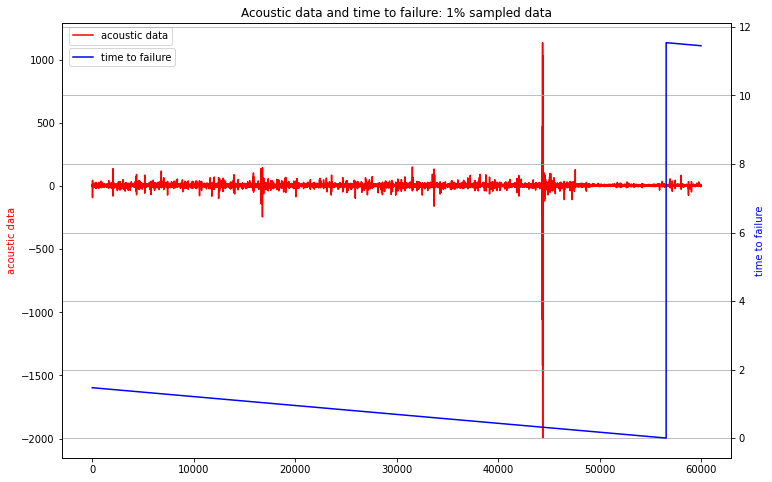

In [11]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [0]:

# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [13]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [16]:
X_train.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [17]:

#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.3776750114110539}}

In [18]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}
